# GridWorld
## A Project Demonstrating the Techniques of Dynamic Programming

The gridworld is a two dimensional grid upon which the agent lives.  
At each timestep, the agent must travel to any of the cells surrounding the one it currently resides in.  
Depending on the cell the agent moves to, it recieves a numerical reward, which it tries to maximise.  

---

We start off by importing some packages and defining the environment - that is, the grid -  itself.

In [1]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt

eps = 1e-9

class Action(Enum):
    N, S, E, W = (10 ** i for i in range(4))


class GridWorld:
    """ A test reinforcement learning environment where
        the agent is to learn to navigate around a grid
        with rewards determined by the tile it lands on
    """

    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.state = (0, 0)

        self.stateReward = np.zeros((rows, cols), np.float64)
        posState = (np.random.randint(0, rows), np.random.randint(0, cols))
        negState = (np.random.randint(0, rows), np.random.randint(0, cols))
        while posState == negState:
            negState = (np.random.randint(0, rows), np.random.randint(0, cols))
        self.stateReward[posState] = 1
        self.stateReward[negState] = -1

    def afterAction(self, state, action):
        """ Returns the state that would be transitioned to
            after given action would be executed from the
            given position
        """

        if action == Action.N:
            return (max(0, state[0] - 1), state[1])
        elif action == Action.S:
            return (min(self.rows - 1, state[0] + 1), state[1])
        elif action == Action.E:
            return (state[0], min(self.cols - 1, state[1] + 1))
        elif action == Action.W:
            return (state[0], max(0, state[1] - 1))
        else:
            print('Invalid action.')
            return state

    def doAction(self, action):
        """ Changes position as per state transition kernel
            and returns numerical reward
        """

        self.state = self.afterAction(self.state, action)
        return self.stateReward[self.state]

Once the environment's definition is ready, we can initialize it with some previously chosen parameters.  
We also set up whatever hyperparameters our learning algorithm uses.  

In [2]:
rows, cols, gamma = 5, 5, 0.5
gw = GridWorld(rows, cols)
print(gw.stateReward)  # The rewards at different cells - the agent is not privy to this information.

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.]]


### Policy Evaluation and Iteration.

We can now perform policy evaluation and iteration. Policy evaluation aims to find out how good our policy is.  
We know a policy is better than another when it has a higher v_pi(s) for all s. In accordance with this,  
policy evaluation finds v_pi iteratively, getting a closer estimate with each iteration using the Bellman equations.  
Once we have v_pi, we can easily get a new, improved policy by acting greedily upon it. In turn we can evaluate  
this new policy and repeat. Eventually, we arrive at the optimal policy. This is called policy iteration.

In [3]:
policyValues = np.zeros((rows, cols), np.float64)  # The policy - information the agent uses to decide what to do.

# This outer loop does policy iteration - once the inner loop finds v_pi it updates the policy to act greedily upon it.
# This guarantees improvement until we achieve an optimal policy.
while True:
    values = np.zeros((rows, cols), np.float64)

    # This inner loop does policy evaluation - when the control breaks out updatedValues contains v_pi.
    while True:
        updatedValues = np.zeros((rows, cols), np.float64)

        it = np.nditer(updatedValues, flags=['multi_index'], op_flags=['writeonly'])
        for updatedValue in it:
            possibleNextStates = [gw.afterAction(it.multi_index, action) for _, action in Action.__members__.items()]
            maxValue = max([policyValues[possibleNextState] for possibleNextState in possibleNextStates])
            nextStates = list(filter(lambda s: np.abs(policyValues[s] - maxValue) <= eps, possibleNextStates))

            for nextState in nextStates:
                updatedValue += values[nextState]
            updatedValue *= gamma / len(nextStates)
            updatedValue += gw.stateReward[it.multi_index]

        if (np.abs(values - updatedValues) <= eps).all():  # This becomes True when the values have converged.
            break

        values = np.copy(updatedValues)

    if (np.abs(policyValues - updatedValues) <= eps).all():  # This becomes True when the policy has converged.
        break

    policyValues = np.copy(updatedValues)

We can now visualise the resulting values.

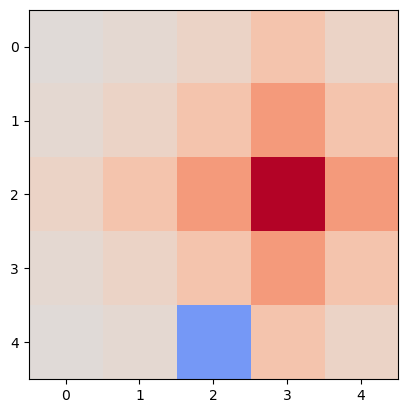

In [4]:
cthresh = np.max(policyValues)
plt.imshow(values, cmap='coolwarm', vmin=-cthresh, vmax=cthresh)  # A visualization of how good the agent thinks each cell is.
plt.show()

And also visualise the policy.

In [5]:
policy = np.zeros((rows, cols), '<U1')
it = np.nditer(policyValues, flags=['multi_index'], op_flags=['writeonly'])
for _ in it:
    possibleNextStates = [gw.afterAction(it.multi_index, action) for _, action in Action.__members__.items()]
    maxValue = max([policyValues[possibleNextState] for possibleNextState in possibleNextStates])

    actionCode = 0
    for _, action in Action.__members__.items():
        if np.abs(policyValues[gw.afterAction(it.multi_index, action)] - maxValue) <= eps:
            actionCode += action._value_

    if actionCode == 1:
        policy[it.multi_index] = '↑'
    elif actionCode == 10:
        policy[it.multi_index] = '↓'
    elif actionCode == 100:
        policy[it.multi_index] = '→'
    elif actionCode == 1000:
        policy[it.multi_index] = '←'
    elif actionCode == 11:
        policy[it.multi_index] = '↕'
    elif actionCode == 1100:
        policy[it.multi_index] = '↔'
    elif actionCode == 1001:
        policy[it.multi_index] = '↖'     
    elif actionCode == 101:
        policy[it.multi_index] = '↗'     
    elif actionCode == 110:
        policy[it.multi_index] = '↘'     
    elif actionCode == 1010:
        policy[it.multi_index] = '↙'
    elif actionCode == 1111:
        policy[it.multi_index] = '✣'   
    else:
        policy[it.multi_index] = '?'

print(policy)

[['↘' '↘' '↘' '↓' '↙']
 ['↘' '↘' '↘' '↓' '↙']
 ['→' '→' '→' '✣' '←']
 ['↗' '↗' '↗' '↑' '↖']
 ['↗' '↑' '↗' '↑' '↖']]


### Value Iteration

Policy iteration involved waiting for policy evaluation to converge over many iterations, then iterating  
to the next policy. In value iteration, we only do one iteration of policy evaluation before moving on to
the next policy. This still works as even a single iteration gives us an improvement over the previous  
and can be faster than policy iteration since it can take may iteration to get from a reasonably good
estimate of v_pi to the optimal one.

In [6]:
values = np.zeros((rows, cols), np.float64)

# Each iteration of this loop improves the policy a little.
while True:
    updatedValues = np.zeros((rows, cols), np.float64)

    it = np.nditer(updatedValues, flags=['multi_index'], op_flags=['writeonly'])
    for updatedValue in it:
        possibleNextStates = [gw.afterAction(it.multi_index, action) for _, action in Action.__members__.items()]
        maxValue = max([values[possibleNextState] for possibleNextState in possibleNextStates])
        nextStates = list(filter(lambda s: np.abs(values[s] - maxValue) <= eps, possibleNextStates))

        for nextState in nextStates:
            updatedValue += values[nextState]
        updatedValue *= gamma / len(nextStates)
        updatedValue += gw.stateReward[it.multi_index]

    if (np.abs(values - updatedValues) <= eps).all():  # This becomes True when the policy has converged.
        break

    values = np.copy(updatedValues)

As with policy iteration, we will now visualise the values.

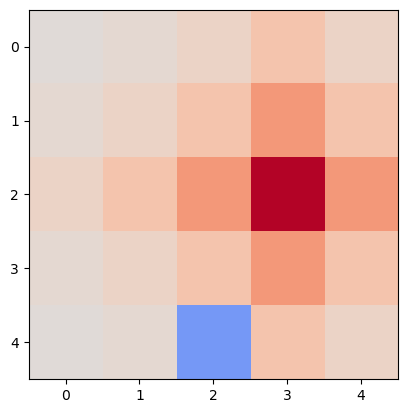

In [7]:
cthresh = np.max(values)
plt.imshow(values, cmap='coolwarm', vmin=-cthresh, vmax=cthresh)
plt.show()

Again, we also visualize the policy.

In [8]:
policy = np.zeros((rows, cols), '<U1')
it = np.nditer(values, flags=['multi_index'], op_flags=['writeonly'])
for _ in it:
    possibleNextStates = [gw.afterAction(it.multi_index, action) for _, action in Action.__members__.items()]
    maxValue = max([values[possibleNextState] for possibleNextState in possibleNextStates])

    actionCode = 0
    for _, action in Action.__members__.items():
        if np.abs(values[gw.afterAction(it.multi_index, action)] - maxValue) <= eps:
            actionCode += action._value_

    if actionCode == 1:
        policy[it.multi_index] = '↑'
    elif actionCode == 10:
        policy[it.multi_index] = '↓'
    elif actionCode == 100:
        policy[it.multi_index] = '→'
    elif actionCode == 1000:
        policy[it.multi_index] = '←'
    elif actionCode == 11:
        policy[it.multi_index] = '↕'
    elif actionCode == 1100:
        policy[it.multi_index] = '↔'
    elif actionCode == 1001:
        policy[it.multi_index] = '↖'     
    elif actionCode == 101:
        policy[it.multi_index] = '↗'     
    elif actionCode == 110:
        policy[it.multi_index] = '↘'     
    elif actionCode == 1010:
        policy[it.multi_index] = '↙'
    elif actionCode == 1111:
        policy[it.multi_index] = '✣'   
    else:
        policy[it.multi_index] = '?'

print(policy)

[['↘' '↘' '↘' '↓' '↙']
 ['↘' '↘' '↘' '↓' '↙']
 ['→' '→' '→' '✣' '←']
 ['↗' '↗' '↗' '↑' '↖']
 ['↗' '↑' '↗' '↑' '↖']]


### END